# Computing the Optimal Growth Model by Dynamic Programming

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Computation of the optimal growth model

Let's consider the following optimal growth model again:

$$
\begin{aligned}
	&\max\int_{0}^{\infty}e^{-\rho t}u(c(t))dt \\
	&\text{subject to} \\
	&\qquad\dot{k}(t)=f(k(t))-\delta k(t)-c(t),\\
	&\qquad k(0):\text{ given.} \\
\end{aligned}
$$

We assume that 

$$
\begin{aligned}
   u(c) &= \frac{c^{1-\theta}}{1-\theta}, \quad \theta > 0, \\
   f(k) &= A k^\alpha, \quad 0 < \alpha < 1, \quad A > 0
\end{aligned}
$$

We will use the following parameters.

In [2]:
alpha = 0.3
delta = 0.05
theta = 5.0
rho = alpha * delta * theta - delta
A = 1

def u(c):
    """utility function"""
    if theta == 1:
        return np.log(c)
    return c**(1 - theta) / (1 - theta)

def f(k):
    """production function"""
    return A * k ** alpha

## Dynamic programing approach

By the method of dynamic programing we know that the value that the objective function attains along the optimal path is a function of initial $k(0) = x$. This function is denoted by 

$$
   v(x)
$$

and is called the value function. It satisfies the following Hamilton-Jacobi-Bellman equation:

$$
   \rho v (x) = \max_c \left[u(c)+v'(x)\left\{ f(x)-\delta x-c\right\} \right], \quad  x \ge 0.
$$


Since the utility maximizing consumption is attained at

$$
   c_{\mathrm{opt}}(x) = (u')^{-1}(v'(x)), 
$$

having $\max$ in the equation doesn't make things hard. ($(u')^{-1}(\cdot)$ is the inverse function of indreasing $u'(\cdot)$).

Here is a trick to compute $v$ iteratively. Consider the following update rule: 

$$
   \frac{v_1(x) - v_0(x)}{\Delta} + \rho v_0(x) = \max_c \left[u(c)+v'_0(x)\left\{ f(x)-\delta x - c\right\} \right],
$$

where $v_0$ is the current guess of the value and $v_1$ is the updated guess:

$$
\begin{aligned}
  v_1(x) 
    &= v_0(x) + \Delta \left(
                      - \rho v_0 (x) + \max_c 
                      \left[
                        u(c)+v'_0(x)\left\{ f(x)-\delta x - c \right\} 
                      \right]
                \right) \\
    &= v_0(x) + \Delta \left[ -\rho v_0(x) + u\left(c_{\mathrm{opt}}(x) \right) + 
                        v'_0(x)\left\{
                           f(x) - \delta x - c_{\mathrm{opt}}(x)
                        \right\}
                \right] \\
    &= (1 - \rho \Delta) v_0(x) + \Delta \left[ u\left(c_{\mathrm{opt}}(x) \right) + 
                        v'_0(x)\left\{
                           f(x) - \delta x - c_{\mathrm{opt}}(x)
                        \right\}
                \right]
\end{aligned}
$$


If you continue this procedure of updating the guess from $v_0$ to $v_1$ and to $v_2, \dots$, until $v_n$ and $v_{n+1}$ are sufficiently close to each other (Technically speaking this is not sufficient for convergence). You will get a good approximation of the true value function $v$.

I will demonstrate this solution method here. You don't have to fully understand the theory at this stage. I adapted the code (for this explicit method) by B. Moll http://www.princeton.edu/~moll/HACTproject/HACT_Additional_Codes.pdf

The below code is not optimized.

In [3]:
ngrid = 250
k = np.linspace(0.01, 10, ngrid)
dk = k[1] - k[0]
Delta = 0.25 * dk / max(f(k) - delta * k)

def du(c):
    """derivative of u"""
    return c**(-theta)

def du_inv(y): 
    """inverse function of the derivative of u"""
    return y**(-1/theta)

def update(v):
    """update rule of the explicit method
    
    Parameter
    ---------
    v: array_like
        Guess of the value function
        
    Returen
    -------
    vnew: array_like
        Updated guess of the value function
        
    dv: array_like
        Numerical derivative of v 
        
    """
    vnew = np.zeros_like(v)
    dv = np.zeros_like(v)
    
    # forward difference
    dvf = np.zeros_like(v)
    dvf[:-1] = (v[1:] - v[:-1]) / dk
    
    # backward difference
    dvb = np.zeros_like(v)
    dvb[1:] = (v[1:] - v[:-1]) / dk
    dvb[0] = du(f(k[0]) - delta * k[0])
    
    muf = f(k) - delta * k - du_inv(dvf)
    mub = f(k) - delta * k - du_inv(dvb)
    
    condlist = [muf > 0, mub < 0, np.logical_and(muf < 0, mub > 0)]
    choicelist = [dvf, dvb, np.full((len(v),), du(f(k) - delta * k))]
    
    dv = np.select(condlist, choicelist)
    c = du_inv(dv)
    
    vnew = (1 - rho * Delta) * v + Delta * (u(c) + dv * (f(k) - delta * k - c))
        
    return vnew, dv

The value function is attained after iteration.

In [4]:
v0 = 0.2 * u(k)
for _ in range(20000):
    v1, vp = update(v0)
    if np.allclose(v1, v0):
        break
    v0 = v1

/Users/kenjisato/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in power
/Users/kenjisato/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in power
/Users/kenjisato/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in greater
/Users/kenjisato/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in less
/Users/kenjisato/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in multiply


Since you have the value function and its derivative, you can immediately compute the policy function (or the consumption function) by 

$$
   c(k) = (u')^{-1}(v'(k)).
$$

/Users/kenjisato/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in power


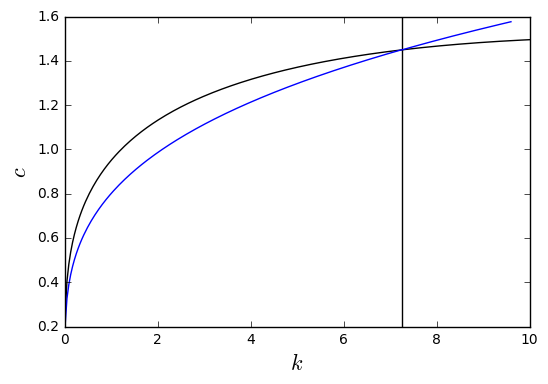

In [5]:
# The modified golden rule capital stock
k_mg = ((delta + rho) / (A * alpha)) ** (1/(alpha - 1))

fig, ax = plt.subplots(1,1)
ax.plot(k, f(k) - delta * k, color='black')
ax.axvline(k_mg, color='black')

ax.set_xlabel('$k$', fontsize=16)
ax.set_ylabel('$c$', fontsize=16)

ax.plot(k, du_inv(vp))

We have carefully chosen the parameter values so that the optimal policy can be analytically solved for. 

To see the computed policy function is correct, let's compare this with the theoretical result. It is known that under our parameter conditions, the optimal growth model satisfies the Solow's assumption regarding the saving rate; i.e., the saving rate, $s$, is constant irrespective of $k$. As a matter of fact,

$$
s = 1 / \theta,
$$

where $\theta$ is the (constant) coefficient of relative risk aversion.

The consumption function therefore becomes

$$
c(k) = (1 - 1/\theta) f(k).
$$

The green plot represents the analytical consumption function and the blue the computed. I added a small deviation to the green because otherwise you cannot see the green one.

/Users/kenjisato/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in power


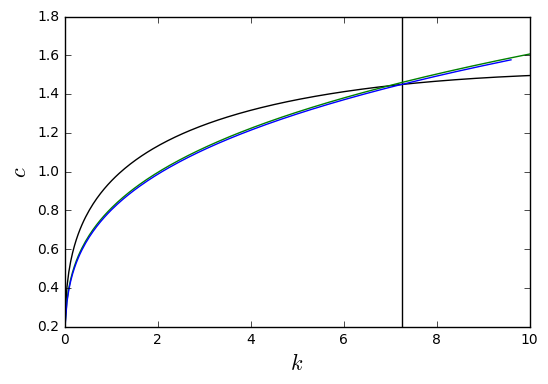

In [15]:
fig, ax = plt.subplots(1,1)
ax.plot(k, f(k) - delta * k, color='black')
ax.axvline(k_mg, color='black')

ax.set_xlabel('$k$', fontsize=16)
ax.set_ylabel('$c$', fontsize=16)

ax.plot(k, (1 - 1/theta) * f(k) + 0.01, color='green')
ax.plot(k, du_inv(vp), color='blue')